In [96]:

import numpy as np
import sys
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim

class qNetworkDiscrete(nn.Module):

    def __init__(self, stateSize, actionSize, layers=[10, 5], activations=[F.tanh, F.tanh], batchNormalization = False, lr=0.01 ):
        '''This is a Q network with discrete actions
        
        This takes a state and returns a Q function for each action. Hence, the
        input is a state and the output is a set of Q values, one for each action
        in the action space. The action is assumed to be discrete. i.e. a ``1``
        when the particular action is to be desired.
        
        Parameters
        ----------
        stateSize : {[type]}
            [description]
        actionSize : {[type]}
            [description]
        layers : {list}, optional
            [description] (the default is [10, 5], which [default_description])
        activations : {list}, optional
            [description] (the default is [F.tanh, F.tanh], which [default_description])
        batchNormalization : {bool}, optional
            [description] (the default is True, which [default_description])
        '''


        try:
            super(qNetworkDiscrete, self).__init__()
            self.stateSize           = stateSize
            self.actionSize          = actionSize
            self.layers              = layers
            self.activations         = activations
            self.batchNormalization  = batchNormalization

            # Generate the fullly connected layer functions
            self.fcLayers = nn.ModuleList([])
            self.bns = nn.ModuleList([])

            oldN = stateSize
            if self.batchNormalization:
                for i, layer in enumerate(layers):
                    self.fcLayers.append( nn.Linear(oldN, layer) )
                    self.bns.append( nn.BatchNorm1d( num_features = layer, track_running_stats=True ) )
                    oldN = layer
            else:
                for i, layer in enumerate(layers):
                    self.fcLayers.append( nn.Linear(oldN, layer) )
                    oldN = layer

            # ------------------------------------------------------
            # The final layer will only need to supply a quality
            # function. This is a single value for an action 
            # provided. Ideally, you would want to provide a 
            # OHE action sequence for most purposes ...
            # ------------------------------------------------------
            self.fcFinal = nn.Linear( oldN, actionSize )

            # we shall put this is eval mode and only use 
            # the trian mode when we need to train the 
            # mode
            self.optimizer = optim.Adam(
                self.parameters(), lr=lr)
        
        except Exception as e:
            raise type(e)( 
                'lib.agents.qNetwork.qNetworkDiscrete.__init__ - ERROR - ' + str(e) 
                ).with_traceback(sys.exc_info()[2])

        return

    def forward(self, x, sigma=0):
        '''forward function that is called during the forward pass
        
        This is the forward function that will be called during a 
        forward pass. It takes thee states and gives the Q value 
        correspondidng to each of the applied actions that are 
        associated with that state. 
        
        Parameters
        ----------
        x : {tensor}
            This is a 2D tensor. 
        
        Returns
        -------
        tensor
            This represents the Q value of the function
        '''

        try:
            if self.batchNormalization:
                for i, (bn, fc, a) in enumerate(zip(self.bns, self.fcLayers, self.activations)):
                    if self.training:
                        bn.train()
                    else:
                        bn.eval()
                    x = a(bn(fc(x)))
                    # https://discuss.pytorch.org/t/random-number-on-gpu/9649
                    if x.is_cuda:
                        normal = torch.cuda.FloatTensor(x.shape).normal_()
                    else:
                        normal = torch.FloatTensor(x.shape).normal_()
                    x = x + normal*sigma

                x = self.fcFinal( x )

            else:
                for i, (fc, a) in enumerate(zip(self.fcLayers, self.activations)):
                    x = a(fc(x))
                    if x.is_cuda:
                        normal = torch.cuda.FloatTensor(x.shape).normal_()
                    else:
                        normal = torch.FloatTensor(x.shape).normal_()
                    x = x + normal*sigma

                x = self.fcFinal( x )

        except Exception as e:
            raise type(e)( 
                'lib.agents.qNetwork.qNetworkDiscrete.forward - ERROR - ' + str(e) 
                ).with_traceback(sys.exc_info()[2])

        return x

    def step(self, v1, v2):
        '''[summary]
        
        [description]
        
        Parameters
        ----------
        v1 : {[type]}
            [description]
        v2 : {[type]}
            [description]
        
        Raises
        ------
        type
            [description]
        '''

        try:
            loss = F.mse_loss(v1, v2)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        except Exception as e:
            raise type(e)( 
                'lib.agents.qNetwork.qNetworkDiscrete.forward - ERROR - ' + str(e) 
                ).with_traceback(sys.exc_info()[2])

        return
        


In [97]:
qn1 = qNetworkDiscrete(2, 2)
qn2 = qNetworkDiscrete(2, 2)

In [98]:
X = torch.normal(0, torch.ones(1000, 2))
Y = 2*(X + torch.normal(0, torch.ones(X.shape)*1)) +3*(X + torch.normal(0, torch.ones(X.shape)*0.5))

In [99]:
import matplotlib.pyplot as plt

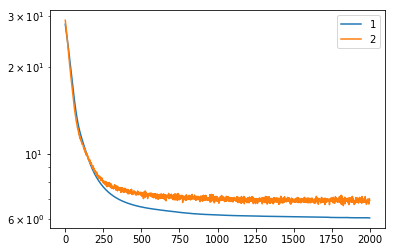

In [100]:
errors1, errors2 = [], []
for i in range(2000):
    yHat1 = qn1.forward(X)
    qn1.step( Y, yHat1 )
    e1 = ((yHat1 - Y)**2).mean()
    errors1.append( e1 )
    
    yHat2 = qn2.forward(X, 0.1)
    qn2.step( Y, yHat2 )
    e2 = ((yHat2 - Y)**2).mean()
    errors2.append( e2 )
    
plt.plot(errors1, label='1')
plt.plot(errors2, label='2')
plt.yscale('log')
plt.legend()
plt.show()

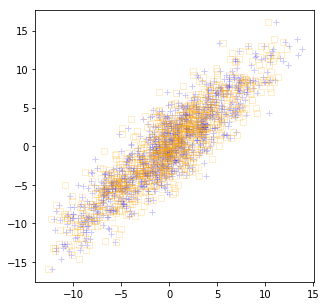

In [65]:
plt.figure(figsize=(5, 5))
plt.plot(yHat1[:, 0].detach().numpy(), Y[:, 0].detach().numpy(), '+', mfc='None', mec='blue', alpha=0.2)
plt.plot(yHat2[:, 0].detach().numpy(), Y[:, 0].detach().numpy(), 's', mfc='None', mec='orange', alpha=0.2)
plt.show()